In [1]:
import torch
import pickle
from tqdm import tqdm
import numpy as np
import random
import pandas as pd

from sentence_transformers import models, SentenceTransformer
from sentence_transformers import InputExample
from torch.utils.data import DataLoader
from sentence_transformers.evaluation import TripletEvaluator

In [2]:
import matplotlib
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import font_manager as fm
from matplotlib import rc

matplotlib.rcParams['figure.dpi'] = 150
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['DejaVu Sans'] 

# I. STS-test 

## STS-test - untrained models

In [3]:
import datasets
from sentence_transformers.evaluation import EmbeddingSimilarityEvaluator

In [4]:
sts = datasets.load_dataset('glue', 'stsb', split='validation')
sts = sts.map(lambda x: {'label': x['label'] / 5.0})

samples = []
for sample in sts:
    samples.append(InputExample(
      texts = [sample['sentence1'], sample['sentence2']],
      label = sample['label']
    ))
    
embedding_evaluator = EmbeddingSimilarityEvaluator.from_input_examples(
    samples, write_csv=False
)

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

TypeError: expected str, bytes or os.PathLike object, not NoneType

In [34]:
bert = models.Transformer('bert-base-uncased')

pooler = models.Pooling(
    bert.get_word_embedding_dimension(), #768
    pooling_mode_mean_tokens=True #mean pooling
)
model1 = SentenceTransformer(modules=[bert, pooler])

embedding_evaluator(model1)

0.6146269526303708

In [35]:
base_sbert = SentenceTransformer('roberta-base-nli-stsb-mean-tokens')    
embedding_evaluator(base_sbert)

0.8770369130817157

## STS - trained models

### finetuned BERT

In [7]:
data_index_list = [0,1,2,3,4]
sts_over_epochs_bert = []
sts_over_epochs_std_bert = []

for epoch in range(1,6,1):

    sts_result = []

    for data_index in data_index_list:
        
        #Load model 
        modelpath = '../model/finetuned-BERT_idx%d_epoch%d'%(data_index, epoch)
        model = SentenceTransformer(modelpath)    
        
        score = embedding_evaluator(model)
        #print(score)
        sts_result.append(score)

    sts_over_epochs_bert.append(np.mean(sts_result))
    sts_over_epochs_std_bert.append(np.std(sts_result))

ValueError: Path ../model/finetuned-BERT_idx0_epoch1 not found

In [37]:
print("%.3f, (%.3f)"%(np.mean(sts_over_epochs_bert[]), np.std(sts_result)))

0.440, (0.027)


###  finetuned S-bert (roberta-base)

In [41]:
data_index_list = [0,1,2,3,4]
sts_over_epochs = []
sts_over_epochs_std = []

for epoch in range(1,6,1):

    sts_result = []
    
    for data_index in data_index_list:
        
        #Load model 
        modelpath = '../model/roberta-base_idx%d_epoch%d'%(data_index, epoch)
        model = SentenceTransformer(modelpath)    
            
        score = embedding_evaluator(model)
        print(score)
        sts_result.append(score)

    sts_over_epochs.append(np.mean(sts_result))
    sts_over_epochs_std.append(np.std(sts_result))

0.7311966320705263
0.7110718601929779
0.7115466790255712
0.70907296023878
0.7262117371757534
0.7146064533764273
0.6760762631195132
0.6762350408090174
0.6673940774202592
0.7034728709698237
0.6970217099399131
0.661459566212627
0.6849389631780571
0.6691990644294201
0.7036321735707216
0.7077246550390359
0.6638325927592007
0.673433166991784
0.6738228345201378
0.6978098427759847
0.7088631558237156
0.6402463700973683
0.675580926479184
0.6606804126507064
0.690518465244212


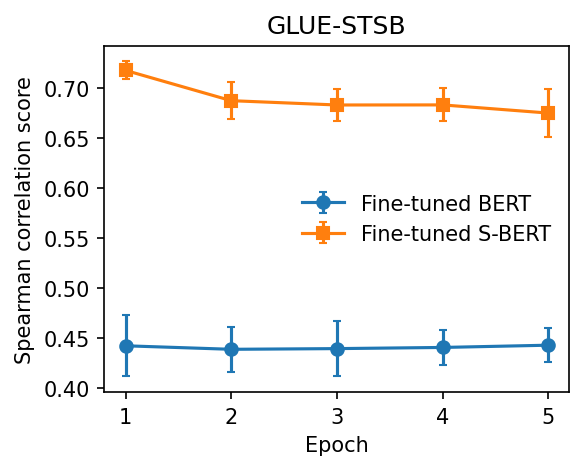

In [78]:
plt.figure(figsize=(4,3))
plt.errorbar(np.arange(1,6,1), sts_over_epochs_bert, yerr=sts_over_epochs_std_bert, fmt='o-', capsize=2, label='Fine-tuned BERT')
plt.errorbar(np.arange(1,6,1), sts_over_epochs, yerr=sts_over_epochs_std, fmt='s-', capsize=2, label='Fine-tuned S-BERT')
plt.title('GLUE-STSB')
plt.legend(frameon=False)
plt.xlabel('Epoch')
plt.ylabel('Spearman correlation score')
plt.xticks(np.arange(1,6,1))
plt.savefig('../fig/GLUE-STSB evaluation.pdf', transparent=True, bbox_inches='tight')
plt.show()

In [77]:
sts_over_epochs_bert

[0.4425311492141425,
 0.4390185490084294,
 0.43971282334435413,
 0.4408744734091403,
 0.4431252272774235]